# Análisis de datos Experimento 1
Con 10% de hábitat en el paisaje, 10 niveles de intensificación y 100 comunidades.

In [1]:
import numpy as np
import seaborn, math, os
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.stats as stats

C:\Anaconda\envs\py35\lib\site-packages\matplotlib\__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [46]:
%matplotlib inline
plt.style.use('seaborn-whitegrid')
seaborn.set_palette("deep", color_codes=True)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['figure.figsize'] = (9, 7)
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13

C:\Anaconda\envs\py35\lib\site-packages\matplotlib\__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
%run medidas_biodiversidad.py


## Funciones para leer datos y calcular medidas

In [4]:
def leer_datos(het):
    files = os.listdir("./datos/exp1")
    files.sort()
    files = list(filter(lambda x: x[6] == het, files))
    
    datos = [np.load("./datos/exp1/" + file) for file in files]
    comunidad = [file[9:12] for file in files]
    
    return datos, comunidad

In [5]:
def calcular_medida(medida, datos, paisajes, bio_min = 5.):
    medidas = np.zeros((100, 10))
    for comunidad in range(len(datos)):
        for intensificacion in range(len(datos[0])):
            medidas[comunidad, intensificacion] = medida(
                                                    datos[comunidad][intensificacion], 
                                                    paisajes[intensificacion],
                                                    t=-2, biomasa_min = bio_min)
    return medidas

In [6]:
def calcular_riqueza(datos, paisajes, bio_min = 5.):
    riquezas = np.zeros((100, 10))
    biomasas = np.zeros((100, 10))

    for comunidad in range(len(datos)):
        for intensificacion in range(len(datos[0])):
            biomasas[comunidad, intensificacion], riquezas[comunidad, intensificacion] = riqueza_agricola(
                                                    datos[comunidad][intensificacion], 
                                                    paisajes[intensificacion],
                                                    t=-2, biomasa_min = bio_min)
    return biomasas, riquezas

In [7]:
def calcular_riquezatotal(datos, bio_min = 5.):
    riquezas = np.zeros((100, 10))
    for comunidad in range(len(datos)):
        for intensificacion in range(len(datos[0])):
            riquezas[comunidad, intensificacion] = riqueza_paisaje(
                                                    datos[comunidad][intensificacion],
                                                    t=-2, biomasa_min = bio_min)[1]
    return riquezas

In [8]:
def calcular_promedio(riquezas):
    """Recibe datos de riqueza.
    """
    promedios = np.zeros(10)
    std = np.zeros(10)
    median = np.zeros(10)
    for i in range(10):
        promedios[i] = np.mean(riquezas[:, i])
        std[i] = np.std(riquezas[:, i])
        median[i] = np.median(riquezas[:, i])
    return promedios, std, median

## Leer datos, calcular promedios, sd

In [9]:
paisajes = [None] * 5
for het in range(5):
    paisajes[het] = np.load("paisajes_h{}.npy".format(het))

In [10]:
datos = [None] * 5
riquezas = [None] * 5
biomasas = [None] * 5

riquezas_mean = [None] * 5
riquezas_sd = [None] * 5
riquezas_median = [None] * 5

biomasas_mean = [None] * 5
biomasas_sd = [None] * 5
biomasas_median = [None] * 5

area = [None] * 5
area_mean = [None] * 5
area_sd = [None] * 5
area_median = [None] * 5

for het in range(5):
    datos[het] = leer_datos(str(het))[0]
    
    biomasas[het], riquezas[het] = calcular_riqueza(datos[het], paisajes[het], bio_min = 15)

    riquezas_mean[het], riquezas_sd[het], riquezas_median[het] = calcular_promedio(riquezas[het])

    area[het] = calcular_medida(medida_area,  datos[het], paisajes[het], bio_min = 15)
    area_mean[het], area_sd[het], area_median[het] = calcular_promedio(area[het])
    
    biomasas_mean[het], biomasas_sd[het], biomasas_median[het] = calcular_promedio(biomasas[het])    

## Graficar

In [57]:
def graficar(medida, promedios, sd):
    """Graficar promedios de una medida de biodiversidad con curva ajustada ponderada
    """
    y = [None] * 5
    res = [None] * 5
    p = [None] * 5
    r2 = [None] * 5

    x = np.linspace(0, 9, 100)
    xdata = np.array(range(10))
    xlabels = np.array(range(10)) * 10 

    puntos = ["o", "p", "d", "v", "s"]
    colors = ['#E6852B', '#23B823', '#9BA7F5','#697CF5','#2F3E9D']

    for het in range(4, -1, -1):
        res[het] = np.polyfit(xdata, promedios[het], 2, w=1/sd[het])
        p[het] = np.poly1d(res[het])
        r2[het] = 1 - ((np.sum((p[het](range(10)) - promedios[het])**2)) / (np.sum((promedios[het] - np.mean(promedios[het]))**2)))
        
    fig = plt.figure()

    for het in range(4, -1, -1):
        y[het] = p[het](x)
        label = '{} \n $y = {:+.3f} x^2 {:+.3f} x {:+.3f}$ \n $R^2={:.4f}$ '.format(
                 het, float(p[het][2]), float(p[het][1]), float(p[het][0]), float(r2[het]))
        
        plt.plot(x, y[het], lw = 4, color= colors[het], label='{}'.format(label)) #fit
        plt.plot(xdata, promedios[het], 'o', color= colors[het]) #data points

    plt.ylim(-0.05)
    plt.xlim(-0.1, 9.1)
    plt.xticks(xdata, xlabels)
    plt.xlabel("% low quality patches")
    plt.ylabel(medida)
    plt.title("{} decline in 10%-habitat landscapes".format(medida))
    plt.legend(loc='center left', title="heterogeneity", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

In [58]:
def graficar_violin(medida, datos, promedios, sd, h):
    """Graficar datos con violin plot
    """
    y = [None] * 5
    res = [None] * 5
    p = [None] * 5
    r2 = [None] * 5

    x = np.linspace(0, 9, 100)
    xdata = np.array(range(10))
    xlabels = np.array(range(10)) * 10 

    puntos = ["o", "p", "d", "v", "s"]
    colors = ['#E6852B', '#23B823', '#9BA7F5','#697CF5','#2F3E9D']

    for het in [h]:
        res[het] = np.polyfit(xdata, promedios[het], 2, w=1/sd[het])
        p[het] = np.poly1d(res[het])
        r2[het] = 1 - ((np.sum((p[het](range(10)) - promedios[het])**2)) / (np.sum((promedios[het] - np.mean(promedios[het]))**2)))
        
    fig = plt.figure()

    for het in [h]:
            y[het] = p[het](x)
            plt.plot(x, y[het], lw = 1, color= colors[het], 
                    label='{} \n $y = {:+.3f} x^2 {:+.3f} x {:+.3f}$ \n $R^2={:.4f}$ '.format(
                    het, float(p[het][2]), float(p[het][1]), float(p[het][0]), float(r2[het]))) #fit
            plt.violinplot(datos[het, :, :], xdata, showmedians=True, showextrema=False, 
                           showmeans=True, widths=0.7, bw_method=0.3) #data points

    plt.ylim(-0.05, 10.1)
    plt.xlim(-0.1, 9.1)
    plt.xticks(xdata, xlabels)
    plt.xlabel("% low quality patches")
    plt.ylabel(medida)
    plt.title("{} decline in 10%-habitat landscapes".format(medida))
    plt.legend(loc='center left', title="heterogeneity", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

In [32]:
def graficar_histogramas(medida, ylim):
    '''Graficar histogramas en het 4, 1, 0; int 0, 3, 6, 9
    '''
    bins = 11
    hrange=(0, 11)
    fig = plt.figure(figsize=(11, 8))
    palette = ['Blues_r', 'Greens_r', 'Oranges_r']
    gs = gridspec.GridSpec(3, 4)
    gs.update(wspace=0.04)
    for i, het in enumerate([4, 1, 0]):
        colors = seaborn.color_palette(palette[i], 5)
        for j, intensification in enumerate([0, 3, 6, 9]):
            ax = plt.subplot(gs[i, j])
            plt.hist(np.array(medida)[het, :, intensification], bins, range=hrange, color=colors[j], 
                         label='{}, {}'.format(het, intensification), width=1, align='left');
            plt.ylim(0, ylim);
            plt.xlim(-0.5, 10.5)
            plt.setp(ax.get_xticklabels(), size=9)
            plt.setp(ax.get_yticklabels(), visible=(intensification==0), size=11)
            plt.setp(ax.get_xgridlines(), visible=False)
            plt.box()
    plt.show() 

In [33]:
def graficar_histogramasb(medida, ylim):
    '''Graficar historgramas en todos los niveles de intensificación y heterogeneidad 
    '''
    bins = 11
    hrange=(0, 11)
    fig = plt.figure(figsize=(15, 10))
    palette = ['Blues_r', 'Blues_r', 'Blues_r', 'Greens_r', 'Oranges_r']
    gs = gridspec.GridSpec(5, 10)
    gs.update(wspace=0.04)
    for i, het in enumerate([4, 3, 2, 1, 0]):
        colors = seaborn.color_palette(palette[i], 10)
        for j, intensification in enumerate([0, 1, 2, 3, 3, 5, 6, 7, 8, 9]):
            ax = plt.subplot(gs[i, j])
            plt.hist(np.array(medida)[het, :, intensification], bins, range=hrange, color=colors[j], 
                         label='{}, {}'.format(het, intensification), width=1, align='left');
            plt.ylim(0, ylim);
            plt.xlim(-0.5, 10.5)
            plt.setp(ax.get_xticklabels(), size=9, visible=(het==0))
            plt.setp(ax.get_yticklabels(), visible=(intensification==0), size=11)
            plt.setp(ax.get_xgridlines(), visible=False)
            plt.box()
    plt.show() 

## Results

### Visualizing data distributions

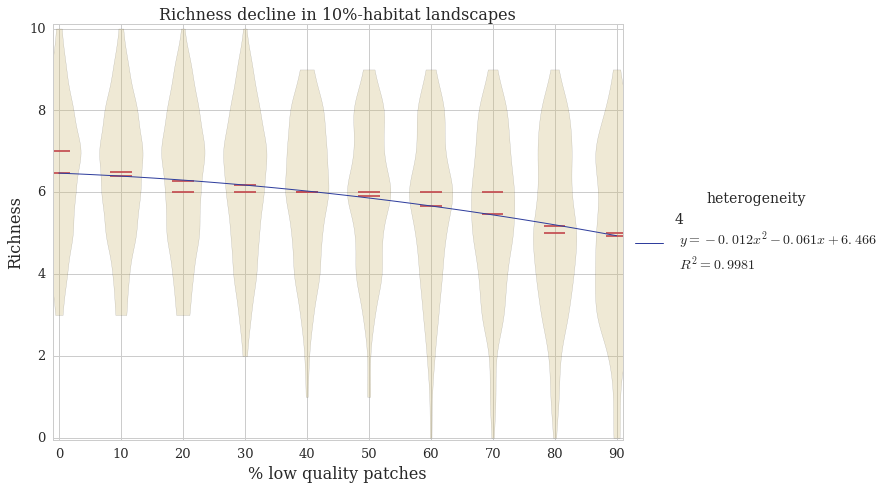

In [59]:
graficar_violin('Richness', np.array(riquezas), riquezas_mean, riquezas_sd, h=4)

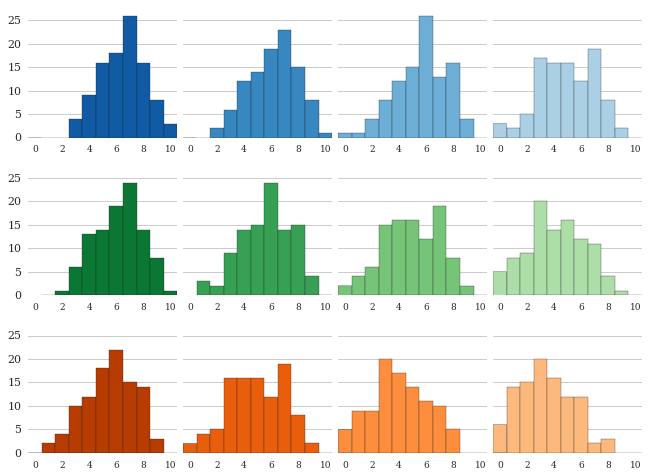

In [35]:
graficar_histogramas(riquezas, ylim=28)

### Species richness

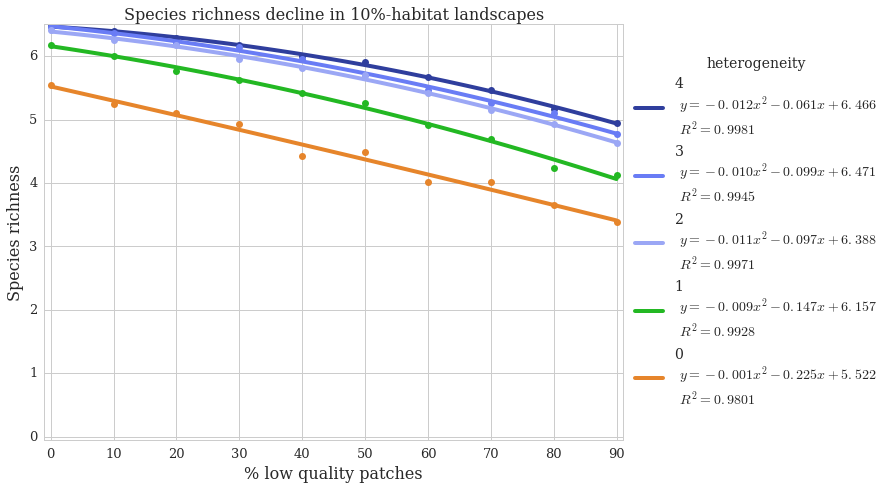

In [60]:
graficar('Species richness', riquezas_mean, riquezas_sd)

### Survival threshold

In [53]:
def graficar_umbral():
    het = 4
    thresholds = [0.0001, 1, 15, 30, 100]
    x = np.linspace(0, 9, 100)
    xdata = np.array(range(10))
    xlabels = np.array(range(10)) * 10 

    colors = seaborn.cubehelix_palette(5, reverse=True, rot = 0.5, light=0.7)
    
    fig = plt.figure()
    
    for i, threshold in enumerate(thresholds):
        r = calcular_riqueza(datos[het], paisajes[het], bio_min = threshold)[1]
        r_mean, r_sd, r_median = calcular_promedio(r)
        res = np.polyfit(xdata, r_mean, 2, w=1/r_sd)
        p = np.poly1d(res)
        r2 = 1 - ((np.sum((p(range(10)) - r_mean)**2)) / (np.sum((r_mean - np.mean(r_mean))**2)))
                
        label = '$y = {:+.3f} x^2 {:+.3f} x {:+.3f}$ \n $R^2={:.4f}$ '.format(
                 float(p[2]), float(p[1]), float(p[0]), float(r2))
        
        plt.plot(x, p(x), lw = 4, color= colors[i], label='{} \n {}'.format(threshold, label)) #fit
        plt.plot(xdata, r_mean, 'o', color= colors[i]) #data points

    plt.ylim(-0.05)
    plt.xlim(-0.1, 9.1)
    plt.xticks(xdata, xlabels)
    plt.xlabel("% low quality patches")
    plt.ylabel('Species richness')
    plt.title("Richness decline in landscapes with \n 10% habitat, high heterogeneity")
    plt.legend(loc='center left', title="survival threshold", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

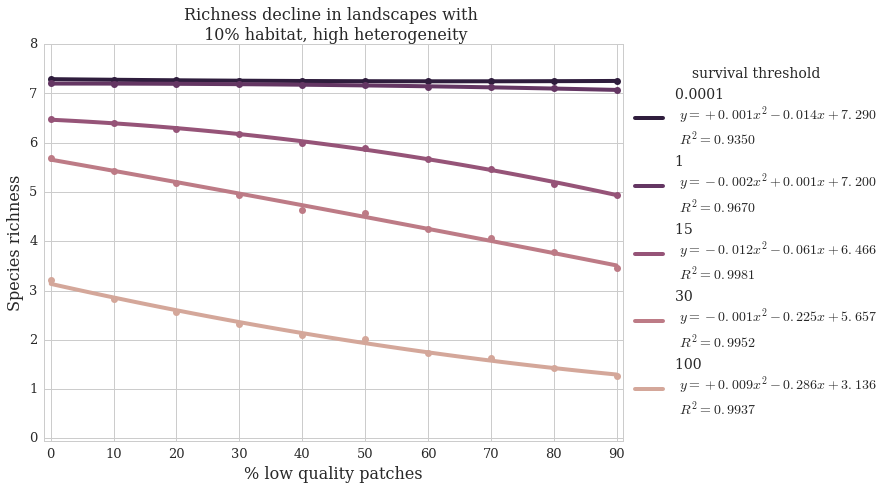

In [54]:
graficar_umbral()

### Biomass

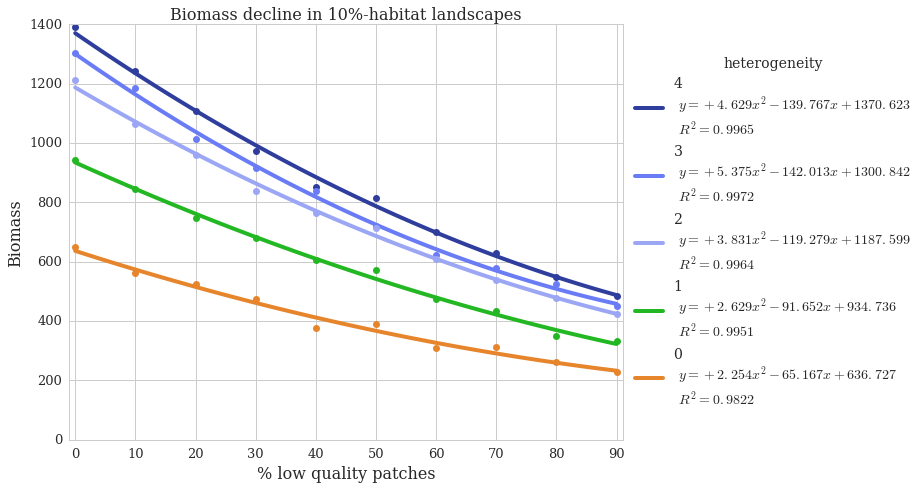

In [61]:
graficar('Biomass', biomasas_mean, biomasas_sd)

### Richness (considering area)

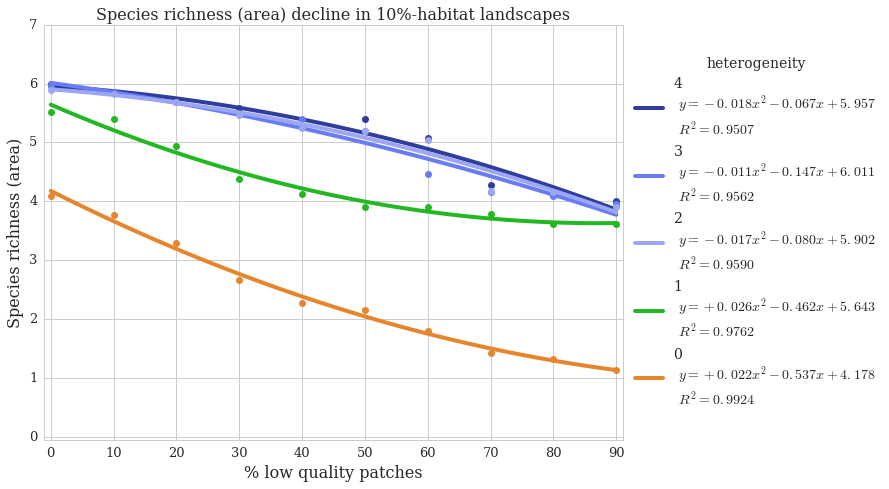

In [62]:
graficar('Species richness (area)', area_mean, area_sd)

## Identifying significant differences in richness

Note: shape of `np.array(biodiversity_measure)` is `[heterogeneity, communities, intensification]`.

### Do data distribute normally?

We use Shapiro-Wilk test. Null hypothesis is that data subsets came from a normally distributed population.

**Result:** Data subsets don't follow a normal distribution. 

In [38]:
for het in range(5):
    for i in range(10):
        res = 'normal'
        
        data = np.array(riquezas)[het, :, i]
        
        pvalue = stats.shapiro(data)[1]
        if pvalue <= 0.05:
            res = '---NOT NORMAL---'
        print('H{}, i{}, p= {:.4f}, {}'.format(het, i, pvalue, res))

H0, i0, p= 0.0036, ---NOT NORMAL---
H0, i1, p= 0.0028, ---NOT NORMAL---
H0, i2, p= 0.0084, ---NOT NORMAL---
H0, i3, p= 0.0057, ---NOT NORMAL---
H0, i4, p= 0.0066, ---NOT NORMAL---
H0, i5, p= 0.0083, ---NOT NORMAL---
H0, i6, p= 0.0059, ---NOT NORMAL---
H0, i7, p= 0.0059, ---NOT NORMAL---
H0, i8, p= 0.0048, ---NOT NORMAL---
H0, i9, p= 0.0032, ---NOT NORMAL---
H1, i0, p= 0.0039, ---NOT NORMAL---
H1, i1, p= 0.0017, ---NOT NORMAL---
H1, i2, p= 0.0014, ---NOT NORMAL---
H1, i3, p= 0.0023, ---NOT NORMAL---
H1, i4, p= 0.0045, ---NOT NORMAL---
H1, i5, p= 0.0054, ---NOT NORMAL---
H1, i6, p= 0.0062, ---NOT NORMAL---
H1, i7, p= 0.0089, ---NOT NORMAL---
H1, i8, p= 0.0049, ---NOT NORMAL---
H1, i9, p= 0.0150, ---NOT NORMAL---
H2, i0, p= 0.0042, ---NOT NORMAL---
H2, i1, p= 0.0049, ---NOT NORMAL---
H2, i2, p= 0.0048, ---NOT NORMAL---
H2, i3, p= 0.0023, ---NOT NORMAL---
H2, i4, p= 0.0008, ---NOT NORMAL---
H2, i5, p= 0.0021, ---NOT NORMAL---
H2, i6, p= 0.0028, ---NOT NORMAL---
H2, i7, p= 0.0064, ---NOT NO

However, using D'Agostino and Pearson's omnibus test, data subsets are normal. Again, null hypothesis is that data subsets came from a normally distributed population.

In [11]:
for het in range(5):
    for i in range(10):
        res = 'normal'
        
        data = np.array(riquezas)[het, :, i]
        
        pvalue = stats.normaltest(data)[1]
        if pvalue <= 0.05:
            res = '---NOT NORMAL---'
        print('H{}, i{}, p= {:.4f}, {}'.format(het, i, pvalue, res))

H0, i0, p= 0.2189, normal
H0, i1, p= 0.0988, normal
H0, i2, p= 0.3392, normal
H0, i3, p= 0.1669, normal
H0, i4, p= 0.2417, normal
H0, i5, p= 0.1456, normal
H0, i6, p= 0.0963, normal
H0, i7, p= 0.0963, normal
H0, i8, p= 0.0531, normal
H0, i9, p= 0.1862, normal
H1, i0, p= 0.1793, normal
H1, i1, p= 0.3245, normal
H1, i2, p= 0.1881, normal
H1, i3, p= 0.2652, normal
H1, i4, p= 0.2961, normal
H1, i5, p= 0.2825, normal
H1, i6, p= 0.1371, normal
H1, i7, p= 0.1355, normal
H1, i8, p= 0.1283, normal
H1, i9, p= 0.1393, normal
H2, i0, p= 0.2983, normal
H2, i1, p= 0.2308, normal
H2, i2, p= 0.2703, normal
H2, i3, p= 0.2883, normal
H2, i4, p= 0.2288, normal
H2, i5, p= 0.2627, normal
H2, i6, p= 0.2358, normal
H2, i7, p= 0.2476, normal
H2, i8, p= 0.1669, normal
H2, i9, p= 0.2085, normal
H3, i0, p= 0.4207, normal
H3, i1, p= 0.2529, normal
H3, i2, p= 0.3186, normal
H3, i3, p= 0.2028, normal
H3, i4, p= 0.2415, normal
H3, i5, p= 0.2096, normal
H3, i6, p= 0.2277, normal
H3, i7, p= 0.2505, normal
H3, i8, p= 0

### Do data have the same variance?

We use Levene test, which does not assume normality. Null hypothesis is that population variances are equal. In particular, we want to know whether data subsets from all heterogeneity levels have the same variance at each intensification level.

**Result:** At each intensification level, richness from all heterogeneity levels has equal variance.

In [19]:
for i in range(10):
    equal_std = 'equal std'
    pvalue = stats.levene(np.array(riquezas)[0, :, i],
                          np.array(riquezas)[1, :, i],
                          np.array(riquezas)[2, :, i],
                          np.array(riquezas)[3, :, i],
                          np.array(riquezas)[4, :, i], center='median')[1]
    if pvalue <=0.05:
        equal_std = '---std NOT EQUAL---'
    print('i{}, pvalue={:.4f}, {}'.format(i, pvalue, equal_std))

i0, pvalue=0.7095, equal std
i1, pvalue=0.2782, equal std
i2, pvalue=0.6527, equal std
i3, pvalue=0.2759, equal std
i4, pvalue=0.1264, equal std
i5, pvalue=0.2328, equal std
i6, pvalue=0.7228, equal std
i7, pvalue=0.8942, equal std
i8, pvalue=0.8925, equal std
i9, pvalue=0.8634, equal std


In [21]:
for i in range(10):
    equal_std = 'equal std'
    pvalue = stats.levene(np.array(area)[0, :, i],
                          np.array(area)[1, :, i],
                          np.array(area)[2, :, i],
                          np.array(area)[3, :, i],
                          np.array(area)[4, :, i], center='median')[1]
    if pvalue <=0.05:
        equal_std = '---std NOT EQUAL---'
    print('i{}, pvalue={:.4f}, {}'.format(i, pvalue, equal_std))

i0, pvalue=0.0888, equal std
i1, pvalue=0.2265, equal std
i2, pvalue=0.5213, equal std
i3, pvalue=0.6308, equal std
i4, pvalue=0.3663, equal std
i5, pvalue=0.2361, equal std
i6, pvalue=0.0361, ---std NOT EQUAL---
i7, pvalue=0.0000, ---std NOT EQUAL---
i8, pvalue=0.0000, ---std NOT EQUAL---
i9, pvalue=0.0000, ---std NOT EQUAL---


We get the same results using Bartlett test.

In [26]:
for i in range(10):
    equal_std = 'equal std'
    pvalue = stats.bartlett(np.array(riquezas)[0, :, i],
                          np.array(riquezas)[1, :, i],
                          np.array(riquezas)[2, :, i],
                          np.array(riquezas)[3, :, i],
                          np.array(riquezas)[4, :, i],)[1]
    if pvalue <=0.05:
        equal_std = '---std NOT EQUAL---'
    print('i{}, pvalue={:.4f}, {}'.format(i, pvalue, equal_std))

i0, pvalue=0.7094, equal std
i1, pvalue=0.4570, equal std
i2, pvalue=0.4988, equal std
i3, pvalue=0.4436, equal std
i4, pvalue=0.3796, equal std
i5, pvalue=0.5498, equal std
i6, pvalue=0.8145, equal std
i7, pvalue=0.9380, equal std
i8, pvalue=0.9632, equal std
i9, pvalue=0.9106, equal std


In [27]:
for i in range(10):
    equal_std = 'equal std'
    pvalue = stats.bartlett(np.array(area)[0, :, i],
                          np.array(area)[1, :, i],
                          np.array(area)[2, :, i],
                          np.array(area)[3, :, i],
                          np.array(area)[4, :, i])[1]
    if pvalue <=0.05:
        equal_std = '---std NOT EQUAL---'
    print('i{}, pvalue={:.4f}, {}'.format(i, pvalue, equal_std))

i0, pvalue=0.1979, equal std
i1, pvalue=0.6171, equal std
i2, pvalue=0.8297, equal std
i3, pvalue=0.8088, equal std
i4, pvalue=0.5854, equal std
i5, pvalue=0.4042, equal std
i6, pvalue=0.0494, ---std NOT EQUAL---
i7, pvalue=0.0001, ---std NOT EQUAL---
i8, pvalue=0.0000, ---std NOT EQUAL---
i9, pvalue=0.0000, ---std NOT EQUAL---


*Extra:* Do data from each heterogeneity level have same variance across the intensification gradient?

**Result:** Yes

In [29]:
for het in range(5):
    equal_std = 'equal std'
    pvalue = stats.levene(np.array(riquezas)[het, :, 0],
                      np.array(riquezas)[het, :, 1],
                      np.array(riquezas)[het, :, 2],
                      np.array(riquezas)[het, :, 3],
                      np.array(riquezas)[het, :, 4],
                      np.array(riquezas)[het, :, 5],
                      np.array(riquezas)[het, :, 6],
                      np.array(riquezas)[het, :, 7],
                      np.array(riquezas)[het, :, 8],
                      np.array(riquezas)[het, :, 9], center='median')[1]
    if pvalue <=0.05:
        equal_std = '---std NOT EQUAL---'
    print('h{}, pvalue={:.4f}, {}'.format(het, pvalue, equal_std))

h0, pvalue=0.9241, equal std
h1, pvalue=0.0749, equal std
h2, pvalue=0.1410, equal std
h3, pvalue=0.1910, equal std
h4, pvalue=0.4070, equal std


In [47]:
for het in range(5):
    equal_std = 'equal std'
    pvalue = stats.levene(np.array(area)[het, :, 0],
                      np.array(area)[het, :, 1],
                      np.array(area)[het, :, 2],
                      np.array(area)[het, :, 3],
                      np.array(area)[het, :, 4],
                      np.array(area)[het, :, 5],
                      np.array(area)[het, :, 6],
                      np.array(area)[het, :, 7],
                      np.array(area)[het, :, 8],
                      np.array(area)[het, :, 9], center='median')[1]
    if pvalue <=0.05:
        equal_std = '---std NOT EQUAL---'
    print('h{}, pvalue={:.4f}, {}'.format(het, pvalue, equal_std))

h0, pvalue=0.0000, ---std NOT EQUAL---
h1, pvalue=0.9685, equal std
h2, pvalue=0.2303, equal std
h3, pvalue=0.1986, equal std
h4, pvalue=0.1681, equal std


### Differences between heterogeneity levels

We use Kruskal test to identify significant differences in biodiversity between heterogeneity levels at each level of intensification. Null hypothesis is that population medians are equal.

There is no significant difference between heterogeneity levels 4, 3 and 2. 

In [30]:
# Richness
for i in range(10):
    res = 'no difference'
    pvalue = stats.kruskal(np.array(riquezas)[4, :, i],
                           np.array(riquezas)[3, :, i],
                           np.array(riquezas)[2, :, i])[1]
    if pvalue <=0.05:
        res = '---DIFFERENT---'
    print('i{}, pvalue={:.4f}, {}'.format(i, pvalue, res))

i0, pvalue=0.9594, no difference
i1, pvalue=0.8519, no difference
i2, pvalue=0.9216, no difference
i3, pvalue=0.6890, no difference
i4, pvalue=0.7684, no difference
i5, pvalue=0.7021, no difference
i6, pvalue=0.6288, no difference
i7, pvalue=0.5032, no difference
i8, pvalue=0.6989, no difference
i9, pvalue=0.6244, no difference


In [31]:
# Area
for i in range(10):
    res = 'no difference'
    pvalue = stats.kruskal(np.array(area)[4, :, i],
                           np.array(area)[3, :, i],
                           np.array(area)[2, :, i])[1]
    if pvalue <=0.05:
        res = '---DIFFERENT---'
    print('i{}, pvalue={:.4f}, {}'.format(i, pvalue, res))

i0, pvalue=0.9055, no difference
i1, pvalue=0.9948, no difference
i2, pvalue=0.9992, no difference
i3, pvalue=0.9077, no difference
i4, pvalue=0.8516, no difference
i5, pvalue=0.6880, no difference
i6, pvalue=0.0825, no difference
i7, pvalue=0.9102, no difference
i8, pvalue=0.9771, no difference
i9, pvalue=0.9553, no difference


Given that data don't seem to differ significantly from normality, we can use ANOVA tests. In this case, null hyphotesis is that group means are equal. We get the same results: There is no significant difference between heterogeneity levels 4, 3 and 2. 

In [43]:
# Richness
for i in range(10):
    res = 'no difference'
    pvalue = stats.f_oneway(np.array(riquezas)[4, :, i],
                           np.array(riquezas)[3, :, i],
                           np.array(riquezas)[2, :, i])[1]
    if pvalue <=0.05:
        res = '---DIFFERENT---'
    print('i{}, pvalue={:.4f}, {}'.format(i, pvalue, res))

i0, pvalue=0.9542, no difference
i1, pvalue=0.8204, no difference
i2, pvalue=0.8997, no difference
i3, pvalue=0.6571, no difference
i4, pvalue=0.7464, no difference
i5, pvalue=0.6757, no difference
i6, pvalue=0.6233, no difference
i7, pvalue=0.5180, no difference
i8, pvalue=0.6899, no difference
i9, pvalue=0.5878, no difference


In [44]:
# Area
for i in range(10):
    res = 'no difference'
    pvalue = stats.f_oneway(np.array(area)[4, :, i],
                           np.array(area)[3, :, i],
                           np.array(area)[2, :, i])[1]
    if pvalue <=0.05:
        res = '---DIFFERENT---'
    print('i{}, pvalue={:.4f}, {}'.format(i, pvalue, res))

i0, pvalue=0.9204, no difference
i1, pvalue=0.9910, no difference
i2, pvalue=0.9991, no difference
i3, pvalue=0.8961, no difference
i4, pvalue=0.8542, no difference
i5, pvalue=0.7224, no difference
i6, pvalue=0.0665, no difference
i7, pvalue=0.9154, no difference
i8, pvalue=0.9780, no difference
i9, pvalue=0.9544, no difference


Heterogeneity levels 4 (highest) and 0 (lowest) are significantly different at all intensification levels.

In [32]:
# Richness
for i in range(10):
    res = 'no difference'
    pvalue = stats.kruskal(np.array(riquezas)[4, :, i],
                           np.array(riquezas)[0, :, i])[1]
    if pvalue <=0.05:
        res = '---DIFFERENT---'
    print('i{}, pvalue={:.4f}, {}'.format(i, pvalue, res))

i0, pvalue=0.0008, ---DIFFERENT---
i1, pvalue=0.0001, ---DIFFERENT---
i2, pvalue=0.0001, ---DIFFERENT---
i3, pvalue=0.0000, ---DIFFERENT---
i4, pvalue=0.0000, ---DIFFERENT---
i5, pvalue=0.0000, ---DIFFERENT---
i6, pvalue=0.0000, ---DIFFERENT---
i7, pvalue=0.0000, ---DIFFERENT---
i8, pvalue=0.0000, ---DIFFERENT---
i9, pvalue=0.0000, ---DIFFERENT---


In [33]:
# Area
for i in range(10):
    res = 'no difference'
    pvalue = stats.kruskal(np.array(area)[4, :, i],
                           np.array(area)[0, :, i])[1]
    if pvalue <=0.05:
        res = '---DIFFERENT---'
    print('i{}, pvalue={:.4f}, {}'.format(i, pvalue, res))

i0, pvalue=0.0000, ---DIFFERENT---
i1, pvalue=0.0000, ---DIFFERENT---
i2, pvalue=0.0000, ---DIFFERENT---
i3, pvalue=0.0000, ---DIFFERENT---
i4, pvalue=0.0000, ---DIFFERENT---
i5, pvalue=0.0000, ---DIFFERENT---
i6, pvalue=0.0000, ---DIFFERENT---
i7, pvalue=0.0000, ---DIFFERENT---
i8, pvalue=0.0000, ---DIFFERENT---
i9, pvalue=0.0000, ---DIFFERENT---


We get the same results using ANOVA.

In [34]:
for i in range(10):
    res = 'no difference'
    pvalue = stats.f_oneway(np.array(riquezas)[4, :, i],
                            np.array(riquezas)[0, :, i])[1]
    if pvalue <=0.05:
        res = '---DIFFERENT---'
    print('i{}, pvalue={:.4f}, {}'.format(i, pvalue, res))

i0, pvalue=0.0002, ---DIFFERENT---
i1, pvalue=0.0000, ---DIFFERENT---
i2, pvalue=0.0000, ---DIFFERENT---
i3, pvalue=0.0000, ---DIFFERENT---
i4, pvalue=0.0000, ---DIFFERENT---
i5, pvalue=0.0000, ---DIFFERENT---
i6, pvalue=0.0000, ---DIFFERENT---
i7, pvalue=0.0000, ---DIFFERENT---
i8, pvalue=0.0000, ---DIFFERENT---
i9, pvalue=0.0000, ---DIFFERENT---


In [16]:
# Area
for i in range(10):
    res = 'no difference'
    pvalue = stats.f_oneway(np.array(area)[4, :, i],
                           np.array(area)[0, :, i])[1]
    if pvalue <=0.05:
        res = '---DIFFERENT---'
    print('i{}, pvalue={:.4f}, {}'.format(i, pvalue, res))

i0, pvalue=0.0000, ---DIFFERENT---
i1, pvalue=0.0000, ---DIFFERENT---
i2, pvalue=0.0000, ---DIFFERENT---
i3, pvalue=0.0000, ---DIFFERENT---
i4, pvalue=0.0000, ---DIFFERENT---
i5, pvalue=0.0000, ---DIFFERENT---
i6, pvalue=0.0000, ---DIFFERENT---
i7, pvalue=0.0000, ---DIFFERENT---
i8, pvalue=0.0000, ---DIFFERENT---
i9, pvalue=0.0000, ---DIFFERENT---


At what intensification levels are heterogeneity levels 4, 1 and 0 different from each other? This is, at what intensification levels is het1 different from het4 and from het0?

In [45]:
# Richness
for i in range(10):
    res = '-'
    pvalue_14 = stats.kruskal(np.array(riquezas)[4, :, i],
                               np.array(riquezas)[1, :, i])[1]
    
    pvalue_10 = stats.kruskal(np.array(riquezas)[0, :, i],
                               np.array(riquezas)[1, :, i])[1]
    if pvalue_14 <=0.05 and pvalue_10 <= 0.05:
        res = '---DIFFERENT---'
    print('i{}, pvalue_14= {:.4f}, pvalue_10= {:.4f}, {}'.format(i, pvalue_14, pvalue_10, res))

i0, pvalue_14= 0.2694, pvalue_10= 0.0232, -
i1, pvalue_14= 0.1485, pvalue_10= 0.0072, -
i2, pvalue_14= 0.0636, pvalue_10= 0.0251, -
i3, pvalue_14= 0.0559, pvalue_10= 0.0192, -
i4, pvalue_14= 0.0400, pvalue_10= 0.0010, ---DIFFERENT---
i5, pvalue_14= 0.0240, pvalue_10= 0.0116, ---DIFFERENT---
i6, pvalue_14= 0.0119, pvalue_10= 0.0034, ---DIFFERENT---
i7, pvalue_14= 0.0095, pvalue_10= 0.0254, ---DIFFERENT---
i8, pvalue_14= 0.0027, pvalue_10= 0.0574, -
i9, pvalue_14= 0.0079, pvalue_10= 0.0138, ---DIFFERENT---


In [36]:
# Area
for i in range(10):
    res = '-'
    pvalue_14 = stats.kruskal(np.array(area)[4, :, i],
                               np.array(area)[1, :, i])[1]
    
    pvalue_10 = stats.kruskal(np.array(area)[0, :, i],
                               np.array(area)[1, :, i])[1]
    if pvalue_14 <=0.05 and pvalue_10 <= 0.05:
        res = '---DIFFERENT---'
    print('i{}, pvalue_14={:.4f}, pvalue_10={:.4f}, {}'.format(i, pvalue_14, pvalue_10, res))

i0, pvalue_14=0.0833, pvalue_10=0.0000, -
i1, pvalue_14=0.1179, pvalue_10=0.0000, -
i2, pvalue_14=0.0104, pvalue_10=0.0000, ---DIFFERENT---
i3, pvalue_14=0.0001, pvalue_10=0.0000, ---DIFFERENT---
i4, pvalue_14=0.0002, pvalue_10=0.0000, ---DIFFERENT---
i5, pvalue_14=0.0000, pvalue_10=0.0000, ---DIFFERENT---
i6, pvalue_14=0.0001, pvalue_10=0.0000, ---DIFFERENT---
i7, pvalue_14=0.1028, pvalue_10=0.0000, -
i8, pvalue_14=0.1115, pvalue_10=0.0000, -
i9, pvalue_14=0.1939, pvalue_10=0.0000, -


When using ANOVA, the range where richness in heterogeneity levels 4, 1 and 0 is distinct increases to 20%-90% (except 80%).

In [17]:
# Richness
for i in range(10):
    res = '-'
    pvalue_14 = stats.f_oneway(np.array(riquezas)[4, :, i],
                               np.array(riquezas)[1, :, i])[1]
    
    pvalue_10 = stats.f_oneway(np.array(riquezas)[0, :, i],
                               np.array(riquezas)[1, :, i])[1]
    if pvalue_14 <=0.05 and pvalue_10 <= 0.05:
        res = '---DIFFERENT---'
    print('i{}, pvalue_14={:.4f}, pvalue_10={:.4f}, {}'.format(i, pvalue_14, pvalue_10, res))

i0, pvalue_14=0.2150, pvalue_10=0.0131, -
i1, pvalue_14=0.1099, pvalue_10=0.0044, -
i2, pvalue_14=0.0400, pvalue_10=0.0181, ---DIFFERENT---
i3, pvalue_14=0.0394, pvalue_10=0.0138, ---DIFFERENT---
i4, pvalue_14=0.0304, pvalue_10=0.0007, ---DIFFERENT---
i5, pvalue_14=0.0183, pvalue_10=0.0085, ---DIFFERENT---
i6, pvalue_14=0.0089, pvalue_10=0.0026, ---DIFFERENT---
i7, pvalue_14=0.0079, pvalue_10=0.0217, ---DIFFERENT---
i8, pvalue_14=0.0020, pvalue_10=0.0530, -
i9, pvalue_14=0.0067, pvalue_10=0.0122, ---DIFFERENT---


Using ANOVA, we get the same results for when species richness (constrained by area) is distinct in heterogeneity levels 4, 1 and 0.

In [18]:
# Area
for i in range(10):
    res = '-'
    pvalue_14 = stats.f_oneway(np.array(area)[4, :, i],
                               np.array(area)[1, :, i])[1]
    
    pvalue_10 = stats.f_oneway(np.array(area)[0, :, i],
                               np.array(area)[1, :, i])[1]
    if pvalue_14 <=0.05 and pvalue_10 <= 0.05:
        res = '---DIFFERENT---'
    print('i{}, pvalue_14={:.4f}, pvalue_10={:.4f}, {}'.format(i, pvalue_14, pvalue_10, res))

i0, pvalue_14=0.0677, pvalue_10=0.0000, -
i1, pvalue_14=0.0928, pvalue_10=0.0000, -
i2, pvalue_14=0.0080, pvalue_10=0.0000, ---DIFFERENT---
i3, pvalue_14=0.0000, pvalue_10=0.0000, ---DIFFERENT---
i4, pvalue_14=0.0001, pvalue_10=0.0000, ---DIFFERENT---
i5, pvalue_14=0.0000, pvalue_10=0.0000, ---DIFFERENT---
i6, pvalue_14=0.0001, pvalue_10=0.0000, ---DIFFERENT---
i7, pvalue_14=0.1036, pvalue_10=0.0000, -
i8, pvalue_14=0.1087, pvalue_10=0.0000, -
i9, pvalue_14=0.1987, pvalue_10=0.0000, -
